<h2>XGBOOST Mini-Version</h2>
<h3>Yiyang "Joe" Zeng</h3>
<h3>Here I tried to create a simplified version of the XGBOOST machine that was originally proposed by Tianqi Chen and Carlos Guestrin. For the original paper, please refer to https://arxiv.org/abs/1603.02754</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

<h2>Step 1: Load Dataset</h2>
<p> a. load dataset</p>
<p> b. check missing values</p>
<p> c. split dataset into 80% train and 20% test sets </p>

In [2]:
# load data
dt = pd.read_csv("customer_attrition.csv")
dt = dt[['days_since_last_loan_expiration','number_of_monthly_transactions','length_of_customer_relationship','number_of_products','size_of_transactions','attrition']]
dt.head()

,days_since_last_loan_expiration,number_of_monthly_transactions,length_of_customer_relationship,number_of_products,size_of_transactions,attrition
0,22,30,12,3,100.56,0
1,17,28,22,1,75.04,0
2,34,26,25,4,53.44,0
3,12,29,34,4,57.34,0
4,10,32,4,3,158.48,0


In [3]:
# check missing values
dt.isnull().sum()

days_since_last_loan_expiration    0
number_of_monthly_transactions     0
length_of_customer_relationship    0
number_of_products                 0
size_of_transactions               0
attrition                          0
dtype: int64

In [4]:
# define X and Y variables
y = dt.iloc[: , -1]
X = dt.iloc[: , :(dt.shape[1]-1)]

# train & test split
# 80% training data + 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

<h2>Step 2: Define Helper Functions for 1st & 2nd Derivatives of the Logistic Loss Function</h2>

In [5]:
# refer to https://github.com/dmlc/xgboost/blob/master/src/objective/regression_loss.h
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# first order gradient
def grad(preds, labels):
    preds = sigmoid(preds)
    return (preds - labels)

# second order gradient
def hess(preds, labels):
    preds = sigmoid(preds)
    return (preds * (1 - preds))

<h2>Step 3: Define a TreeNode Object</h2>
<p>This is an object for a node in a tree model.</p>

In [6]:
class TreeNode(object):
    def __init__(self, is_leaf = False, leaf_score = None, split_feature = None, split_threshold = None, 
                 left_child = None, right_child = None, NA_direction = 'left'):
        self.is_leaf = is_leaf # if True, the node is a leaf and no further split necessary
        self.leaf_score = leaf_score # prediction score
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.left_child = left_child
        self.right_child = right_child
        self.NA_direction = NA_direction # whether to put NA on left or right

<h2>Step 4: Define a Single Tree Object</h2>
<p>This is an object for a tree model.</p>

In [7]:
class Tree(object):
    def __init__(self, root = None, min_sample_split = None, col_sub_frac = None, lamda = None, 
                 gamma = None, num_thread = None, min_child_weight = None):
        self.root = root
        self.min_sample_split = min_sample_split # minimum samples required for a split
        self.col_sub_frac = col_sub_frac # column subsampling fraction
        self.lamda = lamda #lambda
        self.gamma = gamma #gamma
        self.min_child_weight = min_child_weight # minimum weight for a split
    
    def cal_leaf_score(self, Y):
        # calculate score for a leaf
        # Formula (5): -G / (H + Lambda)
        return - (Y['grad'].sum() / (Y['hess'].sum() + self.lamda))
    
    def cal_split_gain(self, left_Y, right_Y, NA_grad, NA_hess, NA_direction = 'left'):
        # calculate gain from a potential split
        # Formula (7): 0.5 * [GL^2 / (HL+Lambda) + GR^2 / (HR+Lambda) - G^2 / (H+Lambda)] - Gamma
        if (NA_direction == 'left'):
            GL = left_Y['grad'].sum() + NA_grad
            HL = left_Y['hess'].sum() + NA_hess
            GR = right_Y['grad'].sum()
            HR = right_Y['hess'].sum()
        else:
            GL = left_Y['grad'].sum()
            HL = left_Y['hess'].sum()
            GR = right_Y['grad'].sum() + NA_grad
            HR = right_Y['hess'].sum() + NA_hess
        gain = 0.5 * ( (GL**2/(HL+self.lamda)) + (GR**2/(HR+self.lamda)) - ((GL+GR)**2/(HL+HR+self.lamda)) ) - self.gamma
        return gain
    
    def weighted_quantile_sketch(self, dt, feature):
        # find the best split value for a given feature
        best_split_value = None
        best_gain = -np.inf
        best_NA_direction = 'left'
        
        selected_dt = dt[[feature, 'label', 'grad', 'hess']]
        
        # divide selected_dt into data with/without NA
        mask = selected_dt[feature].isnull()
        NA_dt = selected_dt[mask]
        Non_NA_dt = selected_dt[~mask]
        
        # for NA data, calculate NA_grad & NA_hess
        NA_grad = NA_dt['grad'].sum()
        NA_hess = NA_dt['hess'].sum()
        
        # for non NA data, order data by feature value
        Non_NA_dt.reset_index(inplace = True)
        Non_NA_dt['feature_index'] = Non_NA_dt[feature].argsort() # assign new index based on feature value
        Non_NA_dt = Non_NA_dt.iloc[Non_NA_dt['feature_index']] # sort
        
        # weighted quantile sketch
        hess_sum = Non_NA_dt['hess'].sum()
        # formula (8)
        Non_NA_dt['rank'] = Non_NA_dt.apply(lambda x : (1/hess_sum)*sum(Non_NA_dt[Non_NA_dt[feature] < x[feature]]['hess']),
                                            axis=1)

        # loop over feature value to find split gain
        for j in range(Non_NA_dt.shape[0]-1):
            
            # look at the current rank and the next rank
            rk_sk_j, rk_sk_j_1 = Non_NA_dt['rank'].iloc[j:j+2]
            
            # formula (9)
            # compare | rk(sk,j) - rk(sk,j+1) | with eps
            if (abs(rk_sk_j-rk_sk_j_1) >= self.eps):
                continue
            
            # if | rk(sk,j) - rk(sk,j+1) | < eps, then propose a split
            split_value = (Non_NA_dt[feature].iloc[j+1] + Non_NA_dt[feature].iloc[j])/2
                
            left_Y = Non_NA_dt.iloc[:(j+1)] # observations before this point are put in the left tree
            right_Y = Non_NA_dt.iloc[(j+1):] # observations after this point are put in the right tree
            
            # decide on where to put NA
            go_left = self.cal_split_gain(left_Y, right_Y, NA_grad, NA_hess, NA_direction = 'left')
            go_right = self.cal_split_gain(left_Y, right_Y, NA_grad, NA_hess, NA_direction = 'right')
            
            if (go_left > go_right):
                this_gain = go_left
                this_direction = 'left'
            else:
                this_gain = go_right
                this_direction = 'right'
            
            # always choose the best gain
            if (this_gain > best_gain):
                best_split_value = split_value
                best_gain = this_gain
                best_NA_direction = this_direction
        
        return feature, best_split_value, best_gain, best_NA_direction
    
    def find_best_split_value_and_feature(self, X, Y):
        best_gain = -np.inf
        best_feature, best_split_value, results = None, None, None
        
        features = list(X.columns) # get a list of all features
        data = pd.concat([X, Y], axis = 1)
        
        results = []
        for j in range(len(features)):
            results.append(self.weighted_quantile_sketch(data, features[j]))
        
        # find the best split
        best = sorted(results, key = lambda x: float(x[2]), reverse = True)[0]
        best_feature = best[0]
        best_split_value = best[1]
        best_gain = best[2]
        best_NA_direction = best[3]
        
        return best_feature, best_split_value, best_gain, best_NA_direction
    
    def split(self, X, Y, feature, split_value, NA_direction):
        data = pd.concat([X, Y], axis = 1)
        X_cols, Y_cols = list(X.columns), list(Y.columns)
        
        if(NA_direction == 'left'):
            mask = (data[feature] >= split_value)
            left = data[~mask] # left take all NA
            right = data[mask]
        else:
            mask = (data[feature] < split_value)
            left = data[mask]
            right = data[~mask] # right take all NA
        
        return left[X_cols], left[Y_cols], right[X_cols], right[Y_cols]
    
    def build_tree(self, X, Y, depth):
        # return a tree node when cannot split
        if (X.shape[0] < self.min_sample_split) or (depth == 0) or (Y['hess'].sum() < self.min_child_weight):
            l_score = self.cal_leaf_score(Y)
            return TreeNode(is_leaf = True, leaf_score = l_score)
        
        # column sub-sampling to reduce overfitting
        X_sub = X.sample(frac = self.col_sub_frac, axis = 1)
        best_feature, best_split_value, best_gain, best_NA_direction = self.find_best_split_value_and_feature(X_sub, Y)
        
        if (best_gain <= 0):
            l_score = self.cal_leaf_score(Y)
            return TreeNode(is_leaf = True, leaf_score = l_score)
        
        # split data
        left_X, left_Y, right_X, right_Y = self.split(X_sub, Y, best_feature, best_split_value, best_NA_direction)
        left_child = self.build_tree(left_X, left_Y, depth - 1)
        right_child = self.build_tree(right_X, right_Y, depth - 1)
        
        # merge two trees together
        sub_tree = TreeNode(is_leaf = False, leaf_score = None, split_feature = best_feature, split_threshold = best_split_value, 
                 left_child = left_child, right_child = right_child, NA_direction = best_NA_direction)
        
        return sub_tree
    
    def fit(self, X, Y, max_depth = 3, min_child_weight = 1, col_sub_frac = 1, min_sample_split = 10, 
            lamda = 1, gamma = 0.05, eps = 0.001):
        self.min_child_weight = min_child_weight
        self.col_sub_frac = col_sub_frac
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.eps = eps
        self.root = self.build_tree(X, Y, max_depth)
    
    def predict_one(self, tree_node, X):
        # predict one observation
        # print predicted score at leaf
        
        if tree_node.is_leaf == True:
            return tree_node.leaf_score
        # if the observation has a missing value for this feature and NA direction is left
        elif (type(X[tree_node.split_feature].item()) != int) and (type(X[tree_node.split_feature].item()) != float) and (tree_node.NA_direction == 'left'):
            return self.predict_one(tree_node.left_child, X)
        
        # if value of the feature is less than the split value
        elif ((X[tree_node.split_feature] < tree_node.split_threshold).item()):
            return self.predict_one(tree_node.left_child, X)
        
        # all else
        else:
            return self.predict_one(tree_node.right_child, X)
        
    def predict(self, X):
        # make predictions
        preds = []
        for n in range(X.shape[0]):
            preds.append(self.predict_one(self.root, X.iloc[[n]]))
        return np.array(preds)

<h2>Step 5: Define a XGBOOST Train Function</h2>
<p>This function is to fit a xgboost machine to training data.</p>

In [8]:
def xgboost_train(X, Y, eta, max_round, max_depth, row_sub_frac, col_sub_frac, min_child_weight, 
                  min_sample_split, lamda, gamma, eps, metric):
    
    # initialize variables
    trees = [] # tree models in this xgboost
    initialize_pred = 1 # initialize a starting point for prediction
    best_metric_value, best_round = -np.inf, None
    metric_value_list = []
    
    # reset index for X & Y
    X.reset_index(drop = True, inplace = True)
    Y = Y.to_frame(name = 'label')
    Y.reset_index(drop = True, inplace = True)
    
    # initialize Y
    Y['y_pred'] = initialize_pred
    Y['grad'] = grad(Y['y_pred'], Y['label'])
    Y['hess'] = hess(Y['y_pred'], Y['label'])
        
    for i in range(max_round):
        data = pd.concat([X, Y], axis = 1)
        # in each boosting round, use row sub-sampling to reduce overfitting
        data = data.sample(frac = row_sub_frac, axis = 0)
            
        Y_Selected = data[['label', 'y_pred', 'grad', 'hess']]
        X_Selected = data[list(X.columns)]
            
        tree = Tree()
        tree.fit(X_Selected, Y_Selected, max_depth = max_depth, min_child_weight = min_child_weight, col_sub_frac = col_sub_frac,
                 min_sample_split = min_sample_split, lamda = lamda, gamma = gamma, eps = eps)
        # predict on the whole training set
        preds = tree.predict(X)
        # eta is a shrinkage factor to prevent overfitting
        Y['y_pred'] = Y['y_pred'] + eta * preds
        Y['grad'] = grad(Y['y_pred'], Y['label'])
        Y['hess'] = hess(Y['y_pred'], Y['label'])
            
        trees.append(tree)
        
        # print out current iteration and its corresponding metric value
        print("Iteration: ", i)
        test_perf = []
        avg = Y['y_pred'].mean()
        for j in Y['y_pred']:
            if (j > avg):
                test_perf.append(1)
            else:
                test_perf.append(0)
        
        # decide on metric to use
        if (metric == 'f1'):
            m = f1_score(Y['label'], test_perf)
            print("F1-Score: ", m)
            metric_value_list.append(m)
        if (metric == 'accuracy'):
            m = accuracy_score(Y['label'], test_perf)
            print("Accuracy: ", m)
        
        # replace best metric
        if (m > best_metric_value):
            best_metric_value = m
            best_round = i
    
    # too many training rounds may cause overfitting and/or decreased performance
    # choose xgboost model when its training metric reaches its maximum
    best_trees = trees[:(i+1)]
    plt.plot(metric_value_list)
    plt.show()
    
    return best_trees, eta

<h2>Step 6: Define a XGBOOST Predict Function</h2>
<p>This function is to predict test data using trained xgboost machine.</p>

In [9]:
def xgboost_predict(trees, X_test, eta):
    # initialize starting point for prediction
    preds = np.ones(X_test.shape[0])
    for tree in trees:
        preds = preds + tree.predict(X_test) * eta
    
    adj_preds = []
    avg = preds.mean()
    for i in preds:
        if (i > avg):
            adj_preds.append(1)
        else:
            adj_preds.append(0)
    
    return adj_preds

<h2>Step 7: Implement the Mini-XGBOOST Machine</h2>
<p>This train function takes about 10-15 minutes to run for 80 training rounds. Let's see the performance.</p>
<p>*Here, I did not do cross-validation and hyperparameter tunning for simplicity, as the purpose is to implement a mini-xgboost. I used some pre-defined hyperparameters.</p>

Iteration:  0
F1-Score:  0.8762886597938144
Iteration:  1
F1-Score:  0.8772845953002611
Iteration:  2
F1-Score:  0.8877005347593583
Iteration:  3
F1-Score:  0.9282051282051282
Iteration:  4
F1-Score:  0.9390862944162437
Iteration:  5
F1-Score:  0.9567430025445293
Iteration:  6
F1-Score:  0.9543147208121828
Iteration:  7
F1-Score:  0.9494949494949495
Iteration:  8
F1-Score:  0.9545454545454546
Iteration:  9
F1-Score:  0.9569620253164557
Iteration:  10
F1-Score:  0.9569620253164557
Iteration:  11
F1-Score:  0.964824120603015
Iteration:  12
F1-Score:  0.9622166246851386
Iteration:  13
F1-Score:  0.9696969696969697
Iteration:  14
F1-Score:  0.9696969696969697
Iteration:  15
F1-Score:  0.9646464646464646
Iteration:  16
F1-Score:  0.9698492462311558
Iteration:  17
F1-Score:  0.9698492462311558
Iteration:  18
F1-Score:  0.9724310776942355
Iteration:  19
F1-Score:  0.9748743718592965
Iteration:  20
F1-Score:  0.9773299748110832
Iteration:  21
F1-Score:  0.9773299748110832
Iteration:  22
F1-Sco

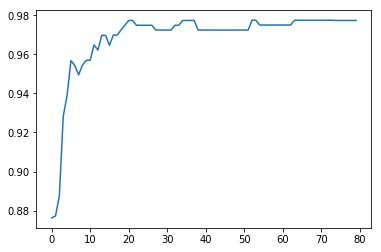

In [10]:
### train the xgboost machine with some pre-defined hyperparameters
model, eta = xgboost_train(X_train, y_train, 
                           eta = 0.4, # shrinkage factor that reduces influence of each individual tree
                           max_round = 80, # the total number of training rounds
                           max_depth = 3, # the max depth for each tree
                           row_sub_frac = 0.95, # sampling percentage of observations used to reduce overfitting
                           col_sub_frac = 1,  # sampling percentage of columns used to reduce overfitting
                           min_child_weight = 1, # min weight for a tree to split
                           min_sample_split = 10, # min sample required for a split
                           lamda = 1, # lambda: L2 regularization term on weights
                           gamma = 0, # gamma(regularization term): minimum loss reduction required for a split
                           eps = 0.003, # epsilon for weighted quantile sketch
                           metric = 'f1') # use f1 score as the evaluation metric to decide the best rounds or the number of trees

[[47  2]
 [ 6 45]]
Test F1 Score:  0.9183673469387754
Test Accuracy:  0.92


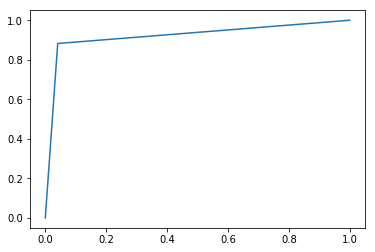

In [11]:
# make predictions on test set
prediction = xgboost_predict(model, X_test, eta)
print(confusion_matrix(y_test, prediction))
print("Test F1 Score: ", f1_score(y_test, prediction))
print("Test Accuracy: ", accuracy_score(y_test, prediction))
fpr, tpr, _ = roc_curve(y_test, prediction)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "auc = " + str(roc_auc))
plt.show()